In [1]:
%env CUDA_VISIBLE_DEVICES ""

env: CUDA_VISIBLE_DEVICES=""


In [2]:
from mp_20_utils import load_all_data
dataset = "mp_20_biternary"
#dataset = "mp_20"
datasets_pd, torch_datasets, site_to_ids, element_to_ids, spacegroup_to_ids, max_len = load_all_data(dataset=dataset)

In [3]:
import torch
from wyckoff_transformer import WyckoffTransformerModel
device = torch.device('cpu')
d_hid = 170  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 3  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 1  # number of heads in ``nn.MultiheadAttention``
dropout = 0.1
# Not all SGs are present in the dataset
n_space_groups = len(spacegroup_to_ids)

model = WyckoffTransformerModel(
    n_space_groups = n_space_groups,
    n_sites = len(site_to_ids),
    n_elements = len(element_to_ids),
    max_enumeration = 7,
    d_space_groups = 16,
    d_sites = 64,
    d_species = 64,
    nhead=nhead,
    d_hid=d_hid,
    max_len=max_len,
    nlayers=nlayers,
    dropout=dropout).to(device)
# mp-20
# model.load_state_dict(torch.load('checkpoints/2024-04-10_04-13-19/best_model_params.pt', map_location=device))
# mp-ternary
# model.load_state_dict(torch.load('checkpoints/2024-05-14_16-17-41/best_model_params.pt', map_location=device))
model.load_state_dict(torch.load('checkpoints/2024-05-17_15-04-28/best_model_params.pt', map_location=device))
model.eval()

WyckoffTransformerModel(
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=145, out_features=145, bias=True)
        )
        (linear1): Linear(in_features=145, out_features=170, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=170, out_features=145, bias=True)
        (norm1): LayerNorm((145,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((145,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (sites_embedding): Embedding(77, 64)
  (species_embedding): Embedding(89, 64)
  (space_groups_embedding): Embedding(172, 16)
  (linear): Linear(in_features=145, out_features=174, bias=True)
)

In [4]:
from torch import optim
from torch import nn

class CalibrateFromLogits(nn.Module):
    def __init__(
        self, lr:float=0.1, max_iter:int=100, n_steps:int=10,
        device:str='cpu'):
        super().__init__()
        self.lr = lr
        self.max_iter = max_iter
        self.n_steps = n_steps
        self.device = device
        self.temperature = nn.Parameter(torch.ones(1, device=device), requires_grad=True)
        self.optimizer = optim.LBFGS([self.temperature], lr=lr, max_iter=max_iter)
        self.criterion = nn.CrossEntropyLoss()
        self.t_max = 2.
    
    def fit(self, logits, targets):
        """
        logits: (batch_size, n_classes)
        targets: (batch_size)
        """
        def calib_eval() -> float:
            self.optimizer.zero_grad()
            scaled_predictions = logits / self.temperature
            loss = self.criterion(scaled_predictions, targets)
            loss.backward()
            return loss
        for i in range(self.n_steps):
            self.optimizer.step(calib_eval)
        #self.temperature = torch.clip(self.temperature, -self.t_max, self.t_max)
        return self

In [5]:
from wyckoff_transformer import get_batches
from tokenization import MASK_SITE
site_mask_tensor=torch.tensor(site_to_ids[MASK_SITE], device=device)
element_pad_tensor = torch.tensor(element_to_ids['PAD'], device=device)
site_pad_tensor = torch.tensor(site_to_ids['PAD'], device=device)
scalers_element = []
scalers_site = []
scalers_enum = []
with torch.no_grad():
    for known_seq_len in range(1, max_len - 1):
        ((data_element, target_element), (data_site, target_site), (data_enumeration, target_enumeration)) = get_batches(
            torch_datasets['val']["symmetry_sites"],
            torch_datasets['val']["symmetry_elements"],
            torch_datasets['val']["symmetry_sites_enumeration"],
            known_seq_len,
            site_mask = site_mask_tensor,
            enumeration_mask = torch.tensor(-1, device=device))
        output_element = model(torch_datasets['val']["spacegroup_number"], **data_element,
                            padding_mask=torch_datasets['val']["padding_mask"][:, :known_seq_len])[0].detach()
        element_mask = target_element != element_pad_tensor
        masked_target_element = target_element[element_mask]
        scalers_element.append(CalibrateFromLogits())
        if masked_target_element.size(0) > 100:
            scalers_element[-1].fit(output_element[element_mask, -1, :], masked_target_element)

        output_site = model(torch_datasets['val']["spacegroup_number"], **data_site,
                            padding_mask=torch_datasets['val']["padding_mask"][:, :known_seq_len + 1])[1].detach()
        site_mask = target_site != site_pad_tensor
        masked_target_site = target_site[site_mask]
        scalers_site.append(CalibrateFromLogits())
        if masked_target_site.size(0) > 100:
            scalers_site[-1].fit(output_site[site_mask, -1, :], masked_target_site)

        output_enumeration = model(torch_datasets['val']["spacegroup_number"], **data_enumeration,
                                   padding_mask=torch_datasets['val']["padding_mask"][:, :known_seq_len + 1])[2]
        enum_mask = target_enumeration != -1
        masked_target_enum = target_enumeration[enum_mask]
        scalers_enum.append(CalibrateFromLogits())
        if masked_target_enum.size(0) > 100:
            scalers_enum[-1].fit(output_enumeration[enum_mask, -1, :], masked_target_enum)

In [6]:
print([s.temperature for s in scalers_element])

[Parameter containing:
tensor([1.3369], requires_grad=True), Parameter containing:
tensor([1.1295], requires_grad=True), Parameter containing:
tensor([0.8238], requires_grad=True), Parameter containing:
tensor([0.8777], requires_grad=True), Parameter containing:
tensor([0.9171], requires_grad=True), Parameter containing:
tensor([0.9629], requires_grad=True), Parameter containing:
tensor([0.9530], requires_grad=True), Parameter containing:
tensor([0.9757], requires_grad=True), Parameter containing:
tensor([1.0576], requires_grad=True), Parameter containing:
tensor([1.0768], requires_grad=True), Parameter containing:
tensor([0.9333], requires_grad=True), Parameter containing:
tensor([1.1117], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True),

In [7]:
print([s.temperature for s in scalers_site])

[Parameter containing:
tensor([1.0967], requires_grad=True), Parameter containing:
tensor([1.0435], requires_grad=True), Parameter containing:
tensor([1.1438], requires_grad=True), Parameter containing:
tensor([1.1778], requires_grad=True), Parameter containing:
tensor([1.1651], requires_grad=True), Parameter containing:
tensor([1.2293], requires_grad=True), Parameter containing:
tensor([1.2215], requires_grad=True), Parameter containing:
tensor([1.0984], requires_grad=True), Parameter containing:
tensor([0.9206], requires_grad=True), Parameter containing:
tensor([0.6053], requires_grad=True), Parameter containing:
tensor([0.9419], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Par

In [8]:
print([s.temperature for s in scalers_enum])

[Parameter containing:
tensor([1.0543], requires_grad=True), Parameter containing:
tensor([0.9925], requires_grad=True), Parameter containing:
tensor([1.0285], requires_grad=True), Parameter containing:
tensor([1.0474], requires_grad=True), Parameter containing:
tensor([0.9701], requires_grad=True), Parameter containing:
tensor([1.0544], requires_grad=True), Parameter containing:
tensor([1.1368], requires_grad=True), Parameter containing:
tensor([1.1836], requires_grad=True), Parameter containing:
tensor([0.8426], requires_grad=True), Parameter containing:
tensor([1.2966], requires_grad=True), Parameter containing:
tensor([1.0043], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True), Par

In [9]:
from torch.nn.functional import softmax
def generate(
    space_groups,
    elements,
    sites,
    enums):
    for i in range(max_len - 2):
        probas_elements = softmax(model(space_groups, sites, elements, enums, None)[0]/scalers_element[i].temperature, -1)
        next_elemenets = torch.multinomial(probas_elements[:, -1, :], 1)
        elements = torch.cat((elements, next_elemenets), 1)

        masked_sites = torch.cat([sites, site_mask_tensor.expand(sites.shape[0], 1)], dim=1)
        masked_enums = torch.cat([enums, torch.tensor(-1, device=device).expand(enums.shape[0], 1)], dim=1)
        probas_sites = softmax(model(space_groups, masked_sites, elements, masked_enums, None)[1]/scalers_site[i].temperature, -1)
        next_sites = torch.multinomial(probas_sites[:, -1, :], 1)
        sites = torch.cat((sites, next_sites), 1)

        probas_enums = softmax(model(space_groups, sites, elements, masked_enums, None)[2]/scalers_enum[i].temperature, -1)
        next_enums = torch.multinomial(probas_enums[:, -1, :], 1)
        enums = torch.cat((enums, next_enums), 1)
    return (elements, sites, enums)

In [10]:
idx_to_element = {idx: element for element, idx in element_to_ids.items()}
idx_to_site = {idx: site for site, idx in site_to_ids.items()}
idx_to_spacegroup = {idx: spacegroup for spacegroup, idx in spacegroup_to_ids.items()}
import pickle
with open("wychoffs_enumerated_by_ss.pkl.gz", "rb") as f:
    _, letter_from_ss_enum, _ = pickle.load(f)
SITE_PAD_ID = site_to_ids["PAD"]
ELEMENT_PAD_ID = element_to_ids["PAD"]
ELEMENT_STOP_ID = element_to_ids["STOP"]

In [11]:
from collections import defaultdict
from pyxtal.symmetry import Group
wp_index = defaultdict(lambda: defaultdict(dict))
for group_number in range(1, 231):
    group = Group(group_number)
    for wp in group.Wyckoff_positions:
        wp.get_site_symmetry()
        wp_index[group_number][wp.site_symm][wp.letter] = (wp.multiplicity, wp.get_dof())

In [12]:
import logging
# logging.basicConfig(level=logging.INFO)
def tensors_to_pyxtal(elements, sites, enums, space_group, enforced_num_elements = None):
    space_group_real = int(idx_to_spacegroup[int(this_spacegroup)])
    pyxtal_args = defaultdict(lambda: [0, []])
    available_sites = deepcopy(wp_index[space_group_real])
    for element_tensor, ss_tensor, enum_tensor in zip(elements, sites, enums):
        if element_tensor == ELEMENT_STOP_ID:
            break
        if element_tensor == ELEMENT_PAD_ID:
            logging.info("PAD element")
            return None
        element = idx_to_element[element_tensor.item()]
        if ss_tensor == SITE_PAD_ID:
            logging.info("PAD site")
            return None
        ss = idx_to_site[ss_tensor.item()]
        try:
            wp_letter = letter_from_ss_enum[space_group_real][ss][enum_tensor.item()]
        except KeyError:
            logging.info("Invalid WP letter")
            return None
        try:
            our_site = available_sites[ss][wp_letter]
        except KeyError:
            logging.info("Repeated special WP")
            return None
        pyxtal_args[element][0] += our_site[0]
        pyxtal_args[element][1].append(str(our_site[0])+wp_letter)
        if our_site[1] == 0: # The position is special
            del available_sites[ss][wp_letter]
    # TODO: move up
    if enforced_num_elements is not None and len(pyxtal_args.keys()) != enforced_num_elements:
        logging.info("Invalid number of elements")
        return None
    return {
            "spacegroup": space_group_real,
            "sites": [x[1] for x in pyxtal_args.values()],
            "elements": list(map(str, pyxtal_args.keys())),
            "composition": [x[0] for x in pyxtal_args.values()]
        }

In [13]:
from collections import Counter
from copy import deepcopy
from random import choice
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

if dataset == "mp_ternary":
  enforced_num_elements = 3
else:
  enforced_num_elements = None


valid_generated = torch.zeros(len(torch_datasets["test"]["spacegroup_number"]), dtype=torch.bool, requires_grad=False)
generated_structures = [None] * len(torch_datasets["test"]["spacegroup_number"])
while not valid_generated.all():
  space_groups = torch_datasets["test"]["spacegroup_number"][~valid_generated]
  elements = torch_datasets["test"]["symmetry_elements"][~valid_generated, 0].view(-1, 1)
  sites = torch_datasets["test"]["symmetry_sites"][~valid_generated, 0].view(-1, 1)
  enums = torch_datasets["test"]["symmetry_sites_enumeration"][~valid_generated, 0].view(-1, 1)
  with torch.no_grad():
    elements, sites, enums = generate(space_groups, elements, sites, enums)

  index = torch.arange(len(valid_generated))[~valid_generated]
  for i, (this_elements, this_sites, this_enums, this_spacegroup) in enumerate(zip(elements, sites, enums, space_groups)):    
    pyxtal_args = tensors_to_pyxtal(this_elements, this_sites, this_enums, this_spacegroup, enforced_num_elements=enforced_num_elements)
    if pyxtal_args is not None:
        generated_structures[index[i]] = pyxtal_args
        valid_generated[index[i]] = True
  print(valid_generated.sum(), valid_generated.size(0), valid_generated.sum()/valid_generated.size(0))

tensor(1253) 7118 tensor(0.1760)
tensor(1554) 7118 tensor(0.2183)
tensor(1683) 7118 tensor(0.2364)
tensor(1741) 7118 tensor(0.2446)


In [ ]:
generated_structures = list(filter(lambda x: x is not None, generated_structures))

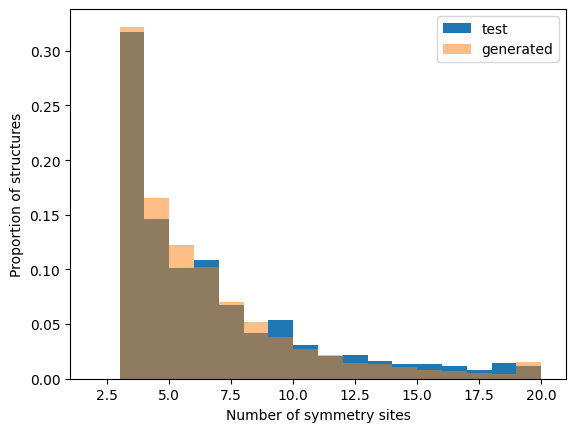

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.arange(1, max_len)
ax.hist(datasets_pd['test'].symmetry_sites.map(len), label="test", density=True, bins=x)
#ax.hist(datasets_pd['train'].symmetry_sites.map(len), label="train", density=True, alpha=0.5, bins=x)
ax.hist(list(map(lambda s: sum(map(len, s['sites'])), generated_structures)), label="generated", density=True, alpha=0.5, bins=x)
ax.set_xlabel("Number of symmetry sites")
ax.set_ylabel("Proportion of structures")
ax.legend()
ax.set_xlim(1, max_len);

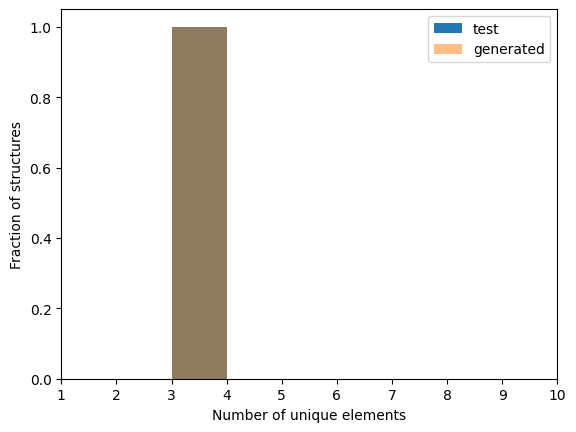

In [ ]:
def count_elements(record):
    return len(set(record["elements"]))
def count_elements_pd(record):
    return len(set(record.structure.elements))
fig, ax = plt.subplots()
bins = np.arange(1, 10)
ax.hist(datasets_pd['test'].apply(count_elements_pd, axis=1), label="test", density=True, bins=bins)
#ax.hist(datasets_pd['train'].apply(count_elements_pd, axis=1), label="train", density=True, alpha=0.5, bins=bins)
ax.hist(list(map(count_elements, generated_structures)), label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Number of unique elements")
ax.set_ylabel("Fraction of structures")
ax.legend()
ax.set_xlim((1,10));

In [ ]:
import pyxtal
example = generated_structures[2]
generator = pyxtal.pyxtal()
generator.from_random(3, group=example["spacegroup"], species=example["elements"],
                      numIons=example["composition"], sites=example["sites"])

In [ ]:
example

{'spacegroup': 71,
 'sites': [['4e'], ['2a'], ['2b']],
 'elements': ['Be', 'Co', 'Ir'],
 'composition': [4, 2, 2]}

In [ ]:
ase_struct = generator.to_ase()
import ase.visualize
ase.visualize.view(ase_struct, viewer="ngl")

In [ ]:
import json
with open(f"generated_{dataset}.json", "w") as f:
    json.dump(generated_structures, f)